# 04. Networks

In [1]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [2]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

In [3]:
# create a geodataframe of 100 random points
np.random.seed(0)
n = 100
df = pd.DataFrame(
    {
        "geometry": gpd.points_from_xy(
            np.random.uniform(-74.3, -73.7, n),
            np.random.uniform(40.5, 40.9, n),
        ),
    }
)

In [4]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

<Axes: >

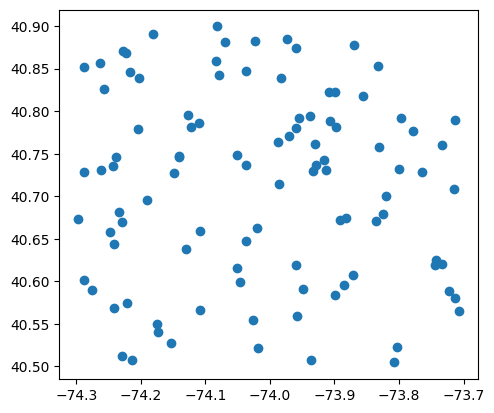

In [5]:
gdf.plot()

In [6]:
gdf

,geometry
0,POINT (-73.97071 40.77113)
1,POINT (-73.87089 40.60800)
2,POINT (-73.93834 40.79408)
3,POINT (-73.97307 40.88488)
4,POINT (-74.04581 40.59950)
...,...
95,POINT (-74.19009 40.69618)
96,POINT (-73.94809 40.59097)
97,POINT (-74.28794 40.60174)
98,POINT (-73.80264 40.52321)


In [11]:
# find five nearest neighbors for each point, not including itself
k = 5
neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(
    axis=1
)[:, 1 : k + 1]

# join neighbors to original dataframe
gdf["neighbors"] = neighbors.tolist()

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_18539/2007509322.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(


In [12]:
gdf

,geometry,neighbors
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]"
1,POINT (-73.87089 40.60800),"[83, 91, 42, 39, 31]"
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]"
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]"
4,POINT (-74.04581 40.59950),"[29, 41, 32, 58, 80]"
...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57, 87, 15]"
96,POINT (-73.94809 40.59097),"[33, 50, 91, 83, 1]"
97,POINT (-74.28794 40.60174),"[75, 69, 67, 15, 92]"
98,POINT (-73.80264 40.52321),"[66, 8, 52, 72, 1]"


In [13]:
def create_lines(r):
    lines = []
    for i, neighbor in enumerate(r.neighbors):
        lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))
    return MultiLineString(lines)

In [14]:
gdf["line_geometry"] = gdf.apply(create_lines, axis=1)

In [15]:
gdf

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]","MULTILINESTRING ((-73.97071 40.77113, -73.9591..."
1,POINT (-73.87089 40.60800),"[83, 91, 42, 39, 31]","MULTILINESTRING ((-73.87089 40.60800, -73.8845..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]","MULTILINESTRING ((-73.97307 40.88488, -73.9600..."
4,POINT (-74.04581 40.59950),"[29, 41, 32, 58, 80]","MULTILINESTRING ((-74.04581 40.59950, -74.0512..."
...,...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57, 87, 15]","MULTILINESTRING ((-74.19009 40.69618, -74.2337..."
96,POINT (-73.94809 40.59097),"[33, 50, 91, 83, 1]","MULTILINESTRING ((-73.94809 40.59097, -73.9589..."
97,POINT (-74.28794 40.60174),"[75, 69, 67, 15, 92]","MULTILINESTRING ((-74.28794 40.60174, -74.2764..."
98,POINT (-73.80264 40.52321),"[66, 8, 52, 72, 1]","MULTILINESTRING ((-73.80264 40.52321, -73.8074..."


In [16]:
lines_gdf = gpd.GeoDataFrame(
    gdf[["line_geometry"]], geometry="line_geometry", crs="EPSG:4326"
)

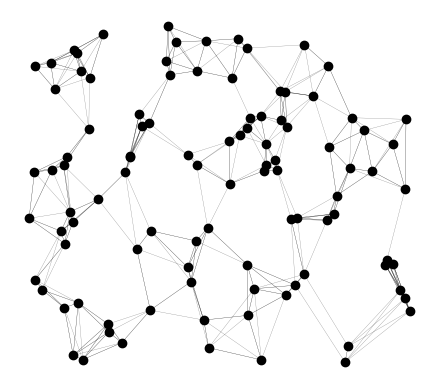

In [17]:
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="black").set_axis_off()
plt.savefig("lines.pdf", bbox_inches="tight", pad_inches=0)

In [21]:
gdf["geometry"].to_file("nodes.geojson", driver="GeoJSON")

In [23]:
gdf["line_geometry"].to_file("edges.geojson", driver="GeoJSON")

In [30]:
gdf.sample(10)

,geometry,neighbors,line_geometry
93,POINT (-73.87020 40.87775),"[18, 74, 44, 56, 84]","MULTILINESTRING ((-73.87020 40.87775, -73.8331..."
22,POINT (-74.02311 40.88243),"[51, 9, 3, 11, 49]","MULTILINESTRING ((-74.02311 40.88243, -74.0368..."
6,POINT (-74.03745 40.73682),"[81, 86, 28, 0, 58]","MULTILINESTRING ((-74.03745 40.73682, -74.0514..."
28,POINT (-73.98689 40.76407),"[0, 12, 88, 86, 2]","MULTILINESTRING ((-73.98689 40.76407, -73.9707..."
80,POINT (-74.10921 40.56588),"[59, 54, 46, 4, 76]","MULTILINESTRING ((-74.10921 40.56588, -74.1533..."
94,POINT (-74.12636 40.79582),"[78, 48, 30, 85, 65]","MULTILINESTRING ((-74.12636 40.79582, -74.1223..."
39,POINT (-73.89091 40.67257),"[42, 31, 5, 10, 1]","MULTILINESTRING ((-73.89091 40.67257, -73.8814..."
11,POINT (-73.98266 40.83856),"[84, 3, 88, 51, 22]","MULTILINESTRING ((-73.98266 40.83856, -73.9600..."
73,POINT (-73.93709 40.50741),"[50, 71, 96, 91, 32]","MULTILINESTRING ((-73.93709 40.50741, -73.9578..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."


<Axes: >

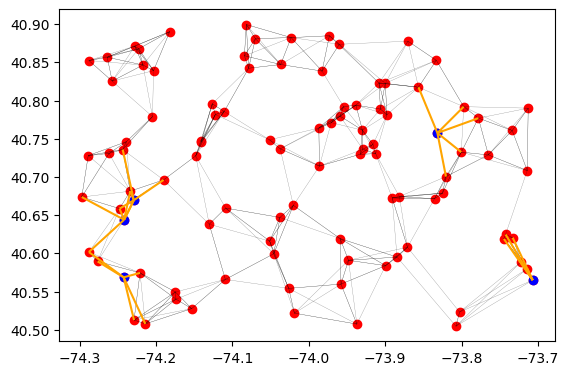

In [26]:
# plot the lines for a single point
s = gdf.sample()
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="red")

s.plot(ax=ax, color="blue")
gpd.GeoSeries(s.line_geometry).plot(ax=plt.gca(), color="orange")

# real-world example


## get restaurants in Morningside Heights


In [31]:
requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
)

<Response [200]>

In [32]:
mh_restaurants = requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
).json()

In [33]:
mh_restaurants

[{'camis': '50142894',
  'dba': 'MANHATTAN SCHOOL OF MUSIC',
  'boro': 'Manhattan',
  'building': '120',
  'street': 'CLAREMONT AVENUE',
  'zipcode': '10027',
  'phone': '7043285184',
  'inspection_date': '1900-01-01T00:00:00.000',
  'critical_flag': 'Not Applicable',
  'record_date': '2024-07-25T06:00:13.000',
  'latitude': '40.812468880147',
  'longitude': '-73.961930662882',
  'community_board': '109',
  'council_district': '07',
  'census_tract': '021100',
  'bin': '1076684',
  'bbl': '1019930001',
  'nta': 'MN09'},
 {'camis': '50153487',
  'dba': 'SUMA SUSHI',
  'boro': 'Manhattan',
  'building': '964',
  'street': 'AMSTERDAM AVENUE',
  'zipcode': '10025',
  'phone': '2122808001',
  'inspection_date': '1900-01-01T00:00:00.000',
  'critical_flag': 'Not Applicable',
  'record_date': '2024-07-25T06:00:13.000',
  'latitude': '40.801328950729',
  'longitude': '-73.965065024806',
  'community_board': '107',
  'council_district': '07',
  'census_tract': '019500',
  'bin': '1056658',
  'b

In [34]:
mh_restaurants = gpd.GeoDataFrame(
    mh_restaurants,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in mh_restaurants],
        [float(x["latitude"]) for x in mh_restaurants],
    ),
)

In [35]:
mh_restaurants.fillna("na", inplace=True)

In [36]:
mh_restaurants.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'inspection_date', 'critical_flag', 'record_date', 'latitude',
       'longitude', 'community_board', 'council_district', 'census_tract',
       'bin', 'bbl', 'nta', 'cuisine_description', 'action', 'violation_code',
       'violation_description', 'score', 'inspection_type', 'grade',
       'grade_date', 'geometry'],
      dtype='object')

In [37]:
mh_restaurants.drop_duplicates(subset="camis", inplace=True)

In [38]:
mh_restaurants.grade.value_counts()

grade
na    78
A     69
B     10
N      8
C      3
Z      1
P      1
Name: count, dtype: int64

In [39]:
mh_restaurants.cuisine_description.value_counts()

cuisine_description
American                          27
Coffee/Tea                        20
na                                16
Chinese                           10
Pizza                             10
Mexican                            8
Italian                            8
Japanese                           5
Juice, Smoothies, Fruit Salads     4
Sandwiches                         4
French                             4
Asian/Asian Fusion                 4
Hamburgers                         4
Ethiopian                          3
Indian                             3
Thai                               3
Other                              3
Frozen Desserts                    2
Greek                              2
Sandwiches/Salads/Mixed Buffet     2
Fusion                             2
Hawaiian                           2
Donuts                             2
Tex-Mex                            2
Latin American                     2
Mediterranean                      2
Bakery Products/De

## build graph to allow us to search


In [40]:
mh_bbox = mh_restaurants.total_bounds

In [41]:
mh_bbox

array([-73.96804436,  40.79882472, -73.9527956 ,  40.81532499])

In [42]:
mh_network = ox.graph_from_bbox(
    mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0], network_type="walk"
)

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_18539/307712133.py:1: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(


In [43]:
mh_network

In [44]:
mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

In [47]:
mh_net_edges

osmid               name  \
u           v           key                                                
42421737    10171363583 0                   195743201  West 106th Street   
            10171363584 0                   420625562    Columbus Avenue   
            10171363585 0                   420625563    Columbus Avenue   
            10171363586 0                   420625567  West 106th Street   
42421741    10166004078 0                   196116970   Amsterdam Avenue   
...                                               ...                ...   
11909145331 11822867881 0    [1283523365, 1273176598]                NaN   
11909145332 11909145337 0                  1283523366                NaN   
            11822867882 0                  1283523364                NaN   
            11909145329 0                  1283523364                NaN   
11909145337 11909145332 0                  1283523366                NaN   

                               highway  oneway reversed  length lanes  \
u           v           key                                             
42421737    10171363583 0    secondary   False     True  12.354   NaN   
            10171363584 0      primary   False     True  12.763     4   
            10171363585 0      primary   False    False  11.700     3   
            10171363586 0    secondary   False     True  12.512     2   
42421741    10166004078 0      primary   False    False  12.881     3   
...                                ...     ...      ...     ...   ...   
11909145331 11822867881 0      footway   False     True  35.704   NaN   
11909145332 11909145337 0        steps   False    False   1.819   NaN   
            11822867882 0      footway   False    False   3.483   NaN   
            11909145329 0      footway   False     True  43.531   NaN   
11909145337 11909145332 0        steps   False     True   1.819   NaN   

                            maxspeed  \
u           v           key            
42421737    10171363583 0        NaN   
            10171363584 0     25 mph   
            10171363585 0     25 mph   
            10171363586 0        NaN   
42421741    10166004078 0        NaN   
...                              ...   
11909145331 11822867881 0        NaN   
11909145332 11909145337 0        NaN   
            11822867882 0        NaN   
            11909145329 0        NaN   
11909145337 11909145332 0        NaN   

                                                                      geometry  \
u           v           key                                                      
42421737    10171363583 0    LINESTRING (-73.96287 40.79924, -73.96275 40.7...   
            10171363584 0    LINESTRING (-73.96287 40.79924, -73.96280 40.7...   
            10171363585 0    LINESTRING (-73.96287 40.79924, -73.96294 40.7...   
            10171363586 0    LINESTRING (-73.96287 40.79924, -73.96300 40.7...   
42421741    10166004078 0    LINESTRING (-73.96569 40.80043, -73.96562 40.8...   
...                                                                        ...   
11909145331 11822867881 0    LINESTRING (-73.96403 40.80105, -73.96402 40.8...   
11909145332 11909145337 0    LINESTRING (-73.96385 40.80126, -73.96387 40.8...   
            11822867882 0    LINESTRING (-73.96385 40.80126, -73.96385 40.8...   
            11909145329 0    LINESTRING (-73.96385 40.80126, -73.96375 40.8...   
11909145337 11909145332 0    LINESTRING (-73.96387 40.80127, -73.96385 40.8...   

                            junction access tunnel bridge width service  
u           v           key                                              
42421737    10171363583 0        NaN    NaN    NaN    NaN   NaN     NaN  
            10171363584 0        NaN    NaN    NaN    NaN   NaN     NaN  
            10171363585 0        NaN    NaN    NaN    NaN   NaN     NaN  
            10171363586 0        NaN    NaN    NaN    NaN   NaN     NaN  
42421741    10166004078 0        NaN    NaN    NaN    NaN   NaN     NaN  
...

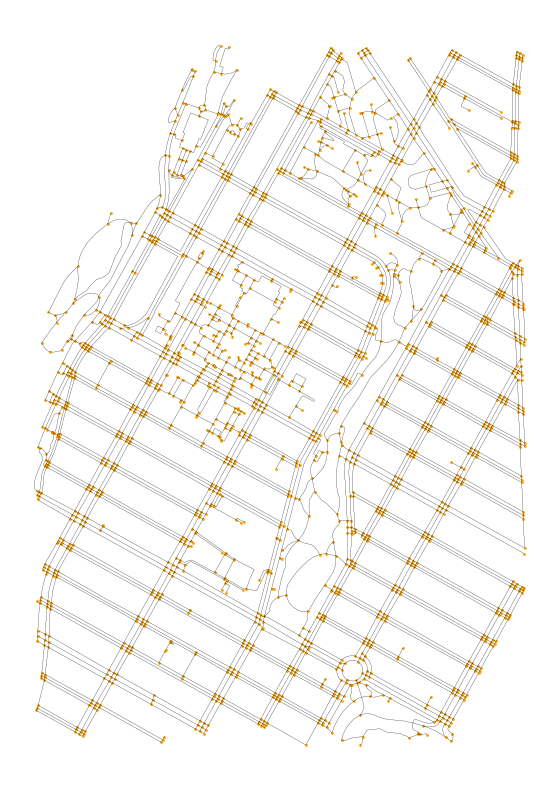

In [50]:
ax = mh_net_edges.plot(color="black", linewidth=0.1, figsize=(10, 10))
mh_net_nodes.plot(ax=ax, color="orange", markersize=1).set_axis_off()

In [51]:
buell_hall = Point(-73.9613315, 40.8077424)

### get directions between avery hall and a random restaurant using osmnx


In [52]:
# get the nearest node to avery hall
orig = ox.distance.nearest_nodes(mh_network, buell_hall.x, buell_hall.y)
sample = mh_restaurants.sample(1)
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]

In [54]:
dest

6791440566

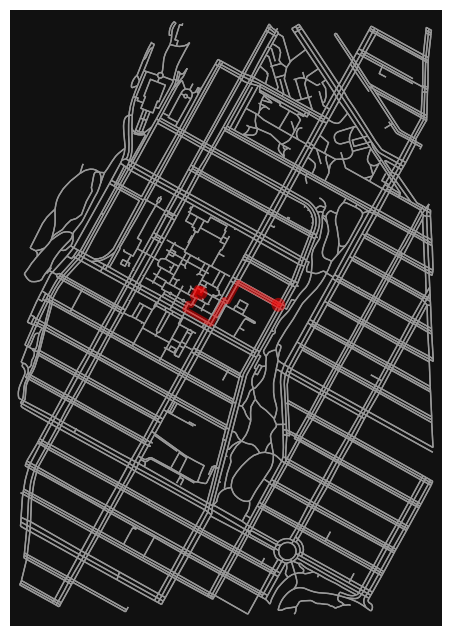

In [55]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(mh_network, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(mh_network, route, node_size=0)

In [61]:
mh_net_edges.reset_index()[["geometry", "highway"]]

# .to_file(
#     "net_edges.geojson", driver="GeoJSON"
# )

,geometry,highway
0,"LINESTRING (-73.96287 40.79924, -73.96275 40.7...",secondary
1,"LINESTRING (-73.96287 40.79924, -73.96280 40.7...",primary
2,"LINESTRING (-73.96287 40.79924, -73.96294 40.7...",primary
3,"LINESTRING (-73.96287 40.79924, -73.96300 40.7...",secondary
4,"LINESTRING (-73.96569 40.80043, -73.96562 40.8...",primary
...,...,...
6441,"LINESTRING (-73.96403 40.80105, -73.96402 40.8...",footway
6442,"LINESTRING (-73.96385 40.80126, -73.96387 40.8...",steps
6443,"LINESTRING (-73.96385 40.80126, -73.96385 40.8...",footway
6444,"LINESTRING (-73.96385 40.80126, -73.96375 40.8...",footway


In [62]:
route

[3579426847,
 2340960621,
 2340960628,
 3907629293,
 2308955266,
 2308955236,
 2340960582,
 2308955275,
 2308955246,
 2308955237,
 2308955273,
 3907629311,
 7323390433,
 3907629310,
 8379835875,
 8379835877,
 8379847753,
 8379847751,
 6791440566]

In [63]:
edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

0.32490026967576774

In [64]:
mh_pizza = mh_restaurants[mh_restaurants.cuisine_description == "Pizza"]

<Axes: >

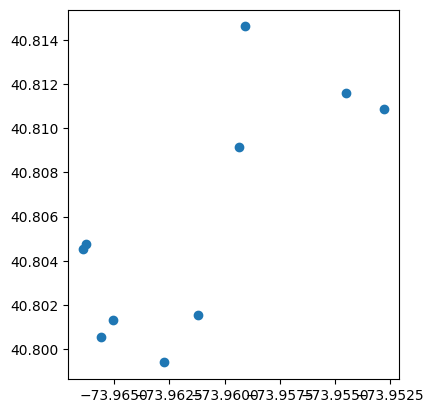

In [65]:
mh_pizza.plot()

In [66]:
def distance_from_point(row, origin):
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    route_geom = route_geom.geometry.unary_union

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}

In [67]:
mh_pizza["distance_from_avery"] = mh_pizza.apply(
    distance_from_point, origin=orig, axis=1
)

/Users/marioag/opt/anaconda3/envs/cdp/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [68]:
mh_pizza["distance_from_avery"]

21     {'distance': 0.4293598618067033, 'route_geom':...
31     {'distance': 0.4293598618067033, 'route_geom':...
52     {'distance': 0.6508786210496229, 'route_geom':...
122    {'distance': 0.6361297177725032, 'route_geom':...
144    {'distance': 0.5626306436178807, 'route_geom':...
157    {'distance': 0.5856649309654891, 'route_geom':...
161    {'distance': 0.27090919258826596, 'route_geom'...
329    {'distance': 0.5982334373097047, 'route_geom':...
617    {'distance': 0.7454117837125778, 'route_geom':...
745    {'distance': 0.7466514223221941, 'route_geom':...
Name: distance_from_avery, dtype: object

In [69]:
# explode the dictionary into separate columns
mh_pizza = pd.concat(
    [
        mh_pizza.drop(["distance_from_avery"], axis=1),
        mh_pizza["distance_from_avery"].apply(pd.Series),
    ],
    axis=1,
)

In [70]:
mh_pizza

,camis,dba,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,...,action,violation_code,violation_description,score,inspection_type,grade,grade_date,geometry,distance,route_geom
21,40388419,FAMOUS FAMIGLIA PIZZERIA,Manhattan,2859,BROADWAY,10025,2128651234,2022-03-09T00:00:00.000,Not Critical,2024-07-25T06:00:10.000,...,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,47,Cycle Inspection / Initial Inspection,na,na,POINT (-73.96626 40.80478),0.429360,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
31,50066109,KORONET PIZZA,Manhattan,2848,BROADWAY,10025,2122221566,2022-04-04T00:00:00.000,Critical,2024-07-25T06:00:10.000,...,Establishment Closed by DOHMH. Violations were...,02B,Hot food item not held at or above 140º F.,58,Cycle Inspection / Initial Inspection,na,na,POINT (-73.96641 40.80454),0.429360,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
52,40605511,DOMINO'S,Manhattan,409,WEST 125 STREET,10027,2122803200,2024-07-09T00:00:00.000,Critical,2024-07-25T06:00:10.000,...,Violations were cited in the following area(s).,04L,Evidence of mice or live mice in establishment...,13,Cycle Inspection / Re-inspection,A,2024-07-09T00:00:00.000,POINT (-73.95451 40.81159),0.650879,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
122,41012973,MAMA'S PIZZERIA,Manhattan,941,AMSTERDAM AVENUE,10025,2125319797,2022-02-10T00:00:00.000,Not Critical,2024-07-25T06:00:10.000,...,Violations were cited in the following area(s).,20F,Current letter grade sign not posted.,na,Administrative Miscellaneous / Initial Inspection,na,na,POINT (-73.96561 40.80055),0.636130,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
144,50065324,GIOVANNI'S ITALIAN PIZZERIA,Manhattan,1011,COLUMBUS AVENUE,10025,2126637000,2023-03-13T00:00:00.000,Critical,2024-07-25T06:00:10.000,...,Violations were cited in the following area(s).,02G,Cold TCS food item held above 41 °F; smoked or...,24,Cycle Inspection / Re-inspection,B,2023-03-13T00:00:00.000,POINT (-73.96121 40.80155),0.562631,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
157,50046844,DOMINO'S,Manhattan,965,AMSTERDAM AVENUE,10025,2122222000,2022-04-05T00:00:00.000,Not Applicable,2024-07-25T06:00:12.000,...,No violations were recorded at the time of thi...,na,na,na,Calorie Posting / Initial Inspection,na,na,POINT (-73.96507 40.80129),0.585665,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
161,50073062,SLICED BY HARLEM PIZZA,Manhattan,1215,AMSTERDAM AVENUE,10027,9177141411,2022-08-30T00:00:00.000,Not Critical,2024-07-25T06:00:10.000,...,Violations were cited in the following area(s).,10F,Non-food contact surface or equipment made of ...,0,Cycle Inspection / Initial Inspection,na,na,POINT (-73.95934 40.80915),0.270909,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
329,50107497,TRUFA PIZZERIA,Manhattan,3161,BROADWAY,10027,9172386330,2024-04-30T00:00:00.000,Critical,2024-07-25T06:00:10.000,...,Violations were cited in the following area(s).,04A,Food Protection Certificate (FPC) not held by ...,60,Cycle Inspection / Initial Inspection,N,na,POINT (-73.95908 40.81462),0.598233,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
617,50131886,IPIZZA,Manhattan,351,WEST 125 STREET,10027,9172658973,2023-04-27T00:00:00.000,Not Critical,2024-07-25T06:00:10.000,...,Violations were cited in the following area(s).,10F,Non-food contact surface or equipment made of ...,3,Cycle Inspection / Initial Inspection,A,2023-04-27T00:00:00.000,POINT (-73.95280 40.81086),0.745412,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
745,50134260,PIZZA HUT,Manhattan,940,COLUMBUS AVENUE,10025,4692840850,2024-04-04T00:00:00.000,Critical,2024-07-25T06:00:10.000,...,Violations were cited in the following area(s).,04A,Food Protection Certificate (FPC) not held by ...,12,Pre-permit (Operational) / Initial Inspection,A,2024-04-04T00:00:00.000,POINT (-73.96277 40.79939),0.746651,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."


In [71]:
mh_pizza_routes = gpd.GeoDataFrame(mh_pizza, geometry="route_geom", crs="EPSG:4326")

Text(0.5, 1.0, 'Distance from Buell Hall to \n Morningside Heights Pizza Restaurants')

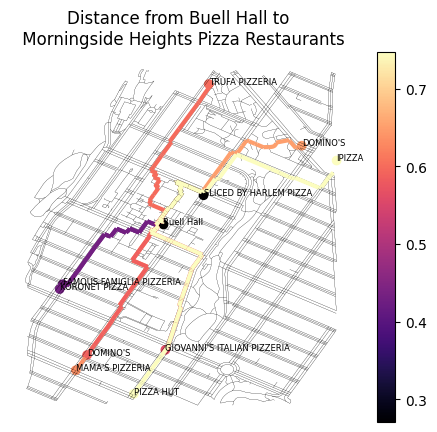

In [74]:
ax = gpd.GeoSeries(buell_hall).plot(color="black")
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
mh_pizza_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
mh_pizza.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()


# label each point
for x, y, label in zip(mh_pizza.geometry.x, mh_pizza.geometry.y, mh_pizza.dba):
    ax.text(x, y, label, fontsize=6)
ax.text(buell_hall.x, buell_hall.y, "Buell Hall", fontsize=6)

# title
plt.title("Distance from Buell Hall to \n Morningside Heights Pizza Restaurants")

In [37]:
mh_pizza[["dba", "distance"]].sort_values("distance")

,dba,distance
14,SLICED BY HARLEM PIZZA,0.246334
41,KORONET PIZZA,0.423456
312,FAMOUS FAMIGLIA PIZZERIA,0.423456
172,GIOVANNI'S ITALIAN PIZZERIA,0.556726
191,TRUFA PIZZERIA,0.573658
194,DOMINO'S,0.579761
19,DOMINO'S,0.626303
10,MAMA'S PIZZERIA,0.630225
346,IPIZZA,0.720836
706,PIZZA HUT,0.740747


<Axes: >

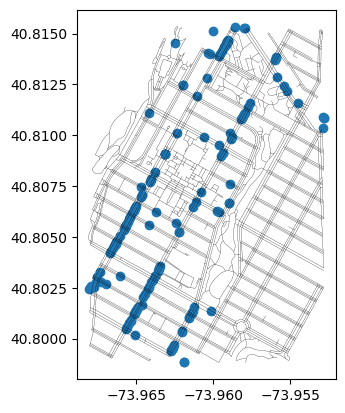

In [38]:
ax = mh_restaurants.plot()
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

In [39]:
# use H3 grid to create a hexagon around the restaurants
# count the number of restaurants in each hexagon
# use pysal to get adjacency between hexagons
# build new network with hexagons as nodes and their adjacency as edges
# use networkx to find the shortest path between hexagons

# get the H3 hexagons

In [ ]:
mh_net_nodes

74 - 76, 88 - 98

,y,x,highway,street_count,geometry
osmid,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,POINT (-73.96287 40.79924)
42421741,40.800429,-73.965691,traffic_signals,4,POINT (-73.96569 40.80043)
42421745,40.801398,-73.967996,traffic_signals,4,POINT (-73.96800 40.80140)
42421852,40.812622,-73.956823,traffic_signals,3,POINT (-73.95682 40.81262)
42421857,40.813822,-73.959800,traffic_signals,4,POINT (-73.95980 40.81382)
...,...,...,...,...,...
11905306939,40.799890,-73.964410,traffic_signals,4,POINT (-73.96441 40.79989)
11909145329,40.801060,-73.964004,NaN,1,POINT (-73.96400 40.80106)
11909145331,40.801052,-73.964028,NaN,1,POINT (-73.96403 40.80105)


In [75]:
mh_net_nodes["h3"] = mh_net_nodes.apply(
    lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, 9), axis=1
)

In [42]:
mh_net_nodes["h3"]

osmid
42421737       892a10088b3ffff
42421741       892a1008887ffff
42421745       892a100888fffff
42421852       892a1008c33ffff
42421857       892a1008c07ffff
                    ...       
11905306939    892a1008887ffff
11909145329    892a1008887ffff
11909145331    892a1008887ffff
11909145332    892a1008887ffff
11909145337    892a1008887ffff
Name: h3, Length: 1906, dtype: object

In [76]:
# create hexagons for AOI
mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(
    lambda x: (h3.h3_to_geo_boundary(x))
)

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_18539/2385662124.py:2: UserWarning: Geometry column does not contain geometry.
  mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(


In [77]:
mh_net_nodes["geometry"]

osmid
42421737       ((40.79992952883273, -73.9619793563826), (40.7...
42421741       ((40.80251489146534, -73.96422198910369), (40....
42421745       ((40.80240003265268, -73.96850268201203), (40....
42421852       ((40.8133159556837, -73.95606838702638), (40.8...
42421857       ((40.8159018703086, -73.95831132341029), (40.8...
                                     ...                        
11905306939    ((40.80251489146534, -73.96422198910369), (40....
11909145329    ((40.80251489146534, -73.96422198910369), (40....
11909145331    ((40.80251489146534, -73.96422198910369), (40....
11909145332    ((40.80251489146534, -73.96422198910369), (40....
11909145337    ((40.80251489146534, -73.96422198910369), (40....
Name: geometry, Length: 1906, dtype: object

In [78]:
# flip order of coordinates for each tuple
mh_net_nodes["geometry"] = mh_net_nodes["geometry"].apply(
    lambda x: Polygon([(y, x) for x, y in x])
)

In [79]:
mh_net_nodes.crs = "EPSG:4326"

In [80]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

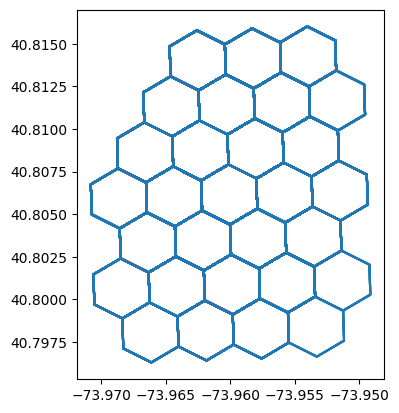

In [82]:
mh_net_nodes.boundary.plot()

In [47]:
# mh_net_edges.to_crs("EPSG:2263", inplace=True)
# mh_net_nodes.to_crs("EPSG:2263", inplace=True)

In [100]:
mh_net_nodes

,y,x,highway,street_count,geometry,h3
osmid,,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,"POLYGON ((-73.96198 40.79993, -73.96409 40.798...",892a10088b3ffff
42421741,40.800429,-73.965691,traffic_signals,4,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff
42421745,40.801398,-73.967996,traffic_signals,4,"POLYGON ((-73.96850 40.80240, -73.97061 40.801...",892a100888fffff
42421852,40.812622,-73.956823,traffic_signals,3,"POLYGON ((-73.95607 40.81332, -73.95818 40.812...",892a1008c33ffff
42421857,40.813822,-73.959800,traffic_signals,4,"POLYGON ((-73.95831 40.81590, -73.96042 40.814...",892a1008c07ffff
...,...,...,...,...,...,...
11905306939,40.799890,-73.964410,traffic_signals,4,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff
11909145329,40.801060,-73.964004,NaN,1,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff
11909145331,40.801052,-73.964028,NaN,1,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff


In [49]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [101]:
mh_net_nodes_copy = mh_net_nodes.copy()

In [104]:
mh_net_nodes_copy.drop_duplicates(subset=["h3"], inplace=True)

In [106]:
mh_net_nodes_copy.shape

(29, 6)

<Axes: >

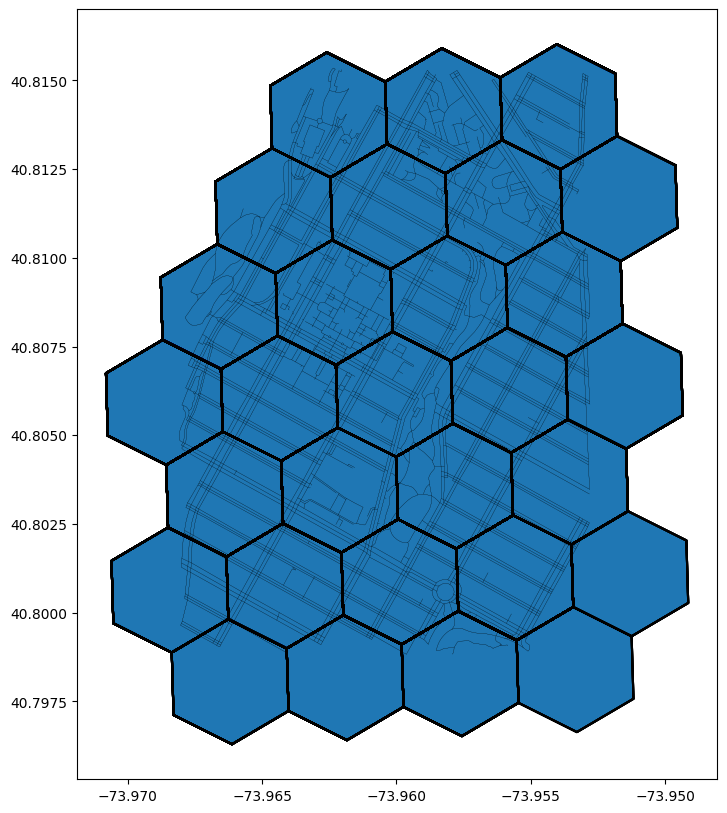

In [107]:
ax = mh_net_nodes_copy.plot(figsize=(10, 10))
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_edges.plot(
    ax=ax,
    color="black",
    linewidth=0.1,
)  # .set_axis_off()

In [108]:
from lonboard import Map, PolygonLayer

In [109]:
layer = PolygonLayer.from_geopandas(
    mh_net_nodes[["geometry"]],
    get_line_color="black",
    get_fill_color="none",
    get_line_width=3,
)
# edges_layer = LineLayer.from_geopandas(
#     mh_net_edges[["geometry"]],
#     get_line_color="black",
#     get_fill_color="none",
#     get_line_width=1,
# )
m = Map(
    [
        layer,
    ]
)
m

Map(layers=[PolygonLayer(get_fill_color=(0, 0, 0, 0), get_line_color=(0, 0, 0, 255), get_line_width=3.0, table…

In [114]:
mh_net_nodes_copy.drop_duplicates(subset="h3", inplace=True)

In [119]:
# create an adjacency matrix for the hexagons
w = lps.weights.Queen.from_dataframe(mh_net_nodes_copy)

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_18539/2291160329.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(mh_net_nodes_copy)


In [120]:
w

In [121]:
# get neighbors for each hexagon
neighbors = {k: v for k, v in w.neighbors.items()}

In [122]:
neighbors

{0: [1, 18, 6, 23],
 1: [0, 2, 23, 6, 7, 13],
 2: [1, 7, 23],
 3: [17, 4, 21, 22, 9, 12],
 4: [9, 3, 5, 22],
 5: [24, 9, 4],
 6: [0, 1, 16, 18, 13, 15],
 7: [1, 2, 8, 13, 14],
 8: [19, 7, 25, 27, 13, 14],
 9: [3, 4, 5, 24, 27, 12],
 10: [17, 11, 20],
 11: [16, 17, 19, 20, 10, 12],
 12: [17, 3, 19, 27, 9, 11],
 13: [16, 1, 19, 6, 7, 8],
 14: [8, 25, 7],
 15: [16, 18, 20, 6, 26, 28],
 16: [19, 20, 6, 11, 13, 15],
 17: [3, 21, 10, 11, 12],
 18: [0, 26, 6, 15],
 19: [16, 8, 27, 11, 12, 13],
 20: [16, 10, 11, 28, 15],
 21: [17, 3, 22],
 22: [3, 4, 21],
 23: [0, 1, 2],
 24: [9, 27, 5, 25],
 25: [8, 24, 27, 14],
 26: [18, 28, 15],
 27: [19, 25, 8, 9, 12, 24],
 28: [26, 20, 15]}

In [123]:
# create networkx graph from adjacency matrix
G = nx.Graph(neighbors)

In [128]:
# get the path between two nodes
path = nx.shortest_path(G, 22, 23)

In [129]:
path

[22, 3, 12, 19, 13, 1, 23]

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_18539/4092262763.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes_copy.geometry.centroid.x,
/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_18539/4092262763.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes_copy.geometry.centroid.y,


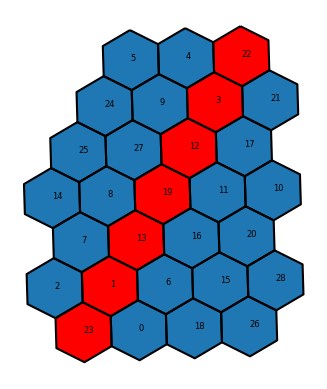

In [130]:
# plot the path
ax = mh_net_nodes_copy.plot()
mh_net_nodes_copy.boundary.plot(ax=ax, color="black")
mh_net_nodes_copy.iloc[path].plot(ax=ax, color="red").set_axis_off()

# label cells with their index
for x, y, label in zip(
    mh_net_nodes_copy.geometry.centroid.x,
    mh_net_nodes_copy.geometry.centroid.y,
    neighbors.keys(),
):
    ax.text(x, y, label, fontsize=6)